# Two Moons with Hug+HOP

In [338]:
import numpy as np
from scipy.linalg import norm, solve
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from two_moons import tm_deterministic, tm_jacobian, tm_distance_gradient
from numpy.random import uniform, normal, rand
from scipy.stats import multivariate_normal as MVN
from pandas import DataFrame as df
from seaborn import pairplot
from scipy.stats import uniform as udist
from scipy.stats import norm as ndist
from numpy import zeros, diag, eye, log, sqrt, vstack, mean, save, exp, linspace, pi
from utils import ESS_univariate, ESS, n_unique
from statsmodels.tsa.stattools import acf
from tangential_hug_functions import HugTangentialStepEJSD_Deterministic, Hop_Deterministic, HugStepEJSD_Deterministic
from tangential_hug_functions import Hop

Let $f:\mathbb{R}^4\to\mathbb{R}$

# Settings

In [19]:
y_star = np.zeros(2)
T = 0.05                    # Integration time for Hug
B = 5                       # Number of steps
delta = T / B               # Step size
N = 10000                   # Number of Hug iterations
epsilon_spherical = 0.05
epsilon_tangential = 0.05
scale = 1.0                 # Scale for the MVN in the spherical case. Equiv to changing B and delta
alpha = 0.6                 # Proportion of the gradient to remove from spherical to make tangential

# Initial Point on Manifold

In [20]:
# Sample randomly the seeds
a0 = uniform(low=-np.pi/2, high=np.pi/2)
r0 = normal(loc=0.1, scale=0.01)

# Start with a guess
guess = np.array([0, 0, a0, r0])

# Find point on manifold using optimization
func = lambda xi: np.r_[tm_deterministic(xi) - y_star, 0, 0]  # Append 0, 0 to make fsolve work.
xi0 = fsolve(func, guess)

# Functions for HUG

Prior distributions

$$
u = (a, r) \qquad \text{with} \qquad p(a) = \mathcal{U}\left(-\frac{\pi}{2}, \frac{\pi}{2}\right)\qquad \text{and}\qquad p(r) = \mathcal{N}(0.1, 0.01^2) \qquad \text{hence} \qquad p(u) = \mathcal{U}\left(-\frac{\pi}{2}, \frac{\pi}{2}\right)\mathcal{N}(0.1, 0.01^2)
$$

$$
p(\theta) = \mathcal{U}\left([-1, 1]\times [-1, 1]\right)
$$

$$
p(\xi) = p(\theta) p(u) = \mathcal{U}\left([-1, 1]\times [-1, 1]\right) \mathcal{U}\left(-\frac{\pi}{2}, \frac{\pi}{2}\right)\mathcal{N}(0.1, 0.01^2)
$$

In [9]:
def logprior(xi):
    """Log prior distribution for Two Moon."""
    t1, t2, a, r = xi
    return udist(loc=-1, scale=2).logpdf(t1) + udist(loc=-1, scale=2).logpdf(t2) + udist(loc=-np.pi/2, scale=np.pi).logpdf(a) + ndist(0.1, 0.01).logpdf(r)

In [236]:
######### IMPORTANT TO DO ################
######### SHOULD CHECK WHETHER TO USE EPSILON OR norm(tm_deterministic(xi) - y_star) here.
# NOTICE THAT WE ARE USING THE DISTANCE MANIFOLD!! THIS IS THE KEY DIFFERENCE TO THE MVN EXAMPLES OF BEFORE. 
# IN MVN EXAMPLES Z0 IS A SCALAR AND SO IS THE OUTPUT OF THE SIMULATOR. HERE, INSTEAD, THE OUTPUT OF THE SIMULATOR 
# HAS 2 DIMENSIONS. HENCE WE CONSIDER THE DISTANCE MANIFOLD INSTEAD. FOR THIS REASON, THE MANIFOLD IS DEFINED BY 
# A VALUE OF THE DISTANCE TO Y_STAR (AS OPPOSED TO MVN EXAMPLE, WHERE IT IS DEFIEND DIRECTLY BY Y_STAR).
grad_function = lambda xi: tm_distance_gradient(xi, y_star, norm(tm_deterministic(xi) - y_star)).flatten()

In [237]:
def log_uniform_kernel(xi, epsilon):
    """Log density of uniform kernel. """
    with np.errstate(divide='ignore'):
        return np.log((norm(tm_deterministic(xi) - y_star) <= epsilon))

In [238]:
def log_abc_posterior(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior(xi) + log_uniform_kernel(xi, epsilon)

In [242]:
def experiment(x00, T1, T2, N, alphas, nlags):
    """Runs Hug+Hop and THUG+HOP using the same velocities and the same random seeds."""
    ### COMMON VARIABLES
    v = q.rvs(N)
    log_uniforms1 = log(rand(N))     # Log uniforms for the HUG kernels
    log_uniforms2 = log(rand(N))     # Log uniforms for the HOP kernel
    u = MVN(zeros(4), eye(4)).rvs(N) # Original velocities for HOP kernel
    ### STORAGE (HUG + HOP)
    hh = x00              # Initial sample
    ahh1 = 0.0            # Acceptance probability for HUG kernel
    ahh2 = 0.0            # Acceptance probability for HOP kernel (when used with HUG)
    ehh = 0.0             # EJSD
    eghh = 0.0            # EJSD in Gradient direction
    ethh = 0.0            # EJSD in Tangent direction
    ### STORAGE (THUG + HOP) I MUST STORE FOR ALL ALPHAS
    ath1 = zeros(n_alphas)
    ath2 = zeros(n_alphas)
    eth  = zeros(n_alphas)
    egth = zeros(n_alphas)
    etth = zeros(n_alphas)
    ### ADDITIONAL STORAGE FOR THUG
    th_esst = zeros(n_alphas)
    th_essu = zeros(n_alphas)
    th_essj = zeros(n_alphas)
    th_uniq = zeros(n_alphas)
    th_act  = zeros((n_alphas, nlags))
    th_acu  = zeros((n_alphas, nlags))
    ### HUG + HOP
    x = x00
    for i in range(N):
        y, a1, e, eg, et = HugStepEJSD_Deterministic(x, v[i], log_uniforms1[i], T1, B, q, log_abc_posterior, grad_function)
        x, a2 = Hop_Deterministic(y, u[i], log_uniforms2[i], lam, kappa, log_abc_posterior, grad_function)
        hh = vstack((hh, y, x))
        ahh1 += a1 * 100 / N
        ahh2 += a2 * 100 / N
        ehh += e / N
        eghh += eg / N 
        ethh += et / N 
    # COMPUTE ESS AND OTHER METRICS FOR HUG
    hh = hh[1:]
    hh_esst = ESS_univariate(hh[::2, 0])     # ESS for theta
    hh_essu = ESS_univariate(hh[::2, 1])     # ESS for u
    hh_essj = ESS(hh[::2])                   # ESS joint
    hh_uniq = n_unique(hh)                             # Number of unique samples
    hh_act  = acf(hh[::2, 0], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for theta (remove the first 1.0)
    hh_acu  = acf(hh[::2, 1], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for u
    ### THUG + HOP
    for k, alpha in enumerate(alphas):
        x = x00
        th = x00      # RESTART THE SAMPLES FROM SCRATCH
        for i in range(N):
            y, a1, e, eg, et = HugTangentialStepEJSD_Deterministic(x, v[i], log_uniforms1[i], T2, B, alpha, q, log_abc_posterior, grad_function)
            x, a2 = Hop_Deterministic(y, u[i], log_uniforms2[i], lam, kappa, log_abc_posterior, grad_function)
            th = vstack((th, y, x))
            ath1[k] += a1 * 100 / N
            ath2[k] += a2 * 100 / N
            eth[k]  += e / N
            egth[k] += eg / N 
            etth[k] += et / N 
        ### COMPUTE ESS AND OTHER METRISC FOR THUG
        th = th[1:]
        th_esst[k] = ESS_univariate(th[::2, 0])     # ESS for theta
        th_essu[k] = ESS_univariate(th[::2, 1])     # ESS for u
        th_essj[k] = ESS(th[::2])                   # ESS joint
        th_uniq[k] = n_unique(th)                             # Number of unique samples
        th_act[k] = acf(th[::2, 0], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for theta
        th_acu[k] = acf(th[::2, 1], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for u
    # RETURN EVERYTHING
    out = {
        'HH': {
            'A1': ahh1,
            'A2': ahh2,
            'E': ehh,
            'EG': eghh, 
            'ET': ethh,
            'ESS_T': hh_esst,
            'ESS_U': hh_essu,
            'ESS_J': hh_essj,
            'UNIQUE': hh_uniq,
            'AC_T': hh_act,
            'AC_U': hh_acu,
            'T': T1,
            'SAMPLES': hh
        },
        'TH': {
            'A1': ath1,
            'A2': ath2,
            'E': eth,
            'EG': egth, 
            'ET': etth, 
            'ESS_T': th_esst,
            'ESS_U': th_essu,
            'ESS_J': th_essj,
            'UNIQUE': th_uniq,
            'AC_T': th_act,
            'AC_U': th_acu,
            'T': T2,
            'SAMPLES': th
        }
    }
    return out

In [243]:
q = MVN(zeros(4), eye(4))

In [466]:
alphas = [0.9]
n_alphas = len(alphas)
epsilon = 0.05
lam = epsilon 
kappa = 0.0005

- /1000: 23, 10
- /500:  16, 15
- /5   : 12, 12
- /2   : 6, 6
- *1  :  2, 2
- *10 :  0.06, 0.06  (but both modes achieved by THUG)

In [467]:
out = experiment(xi0, 0.02, 0.02, 50000, alphas, 20)

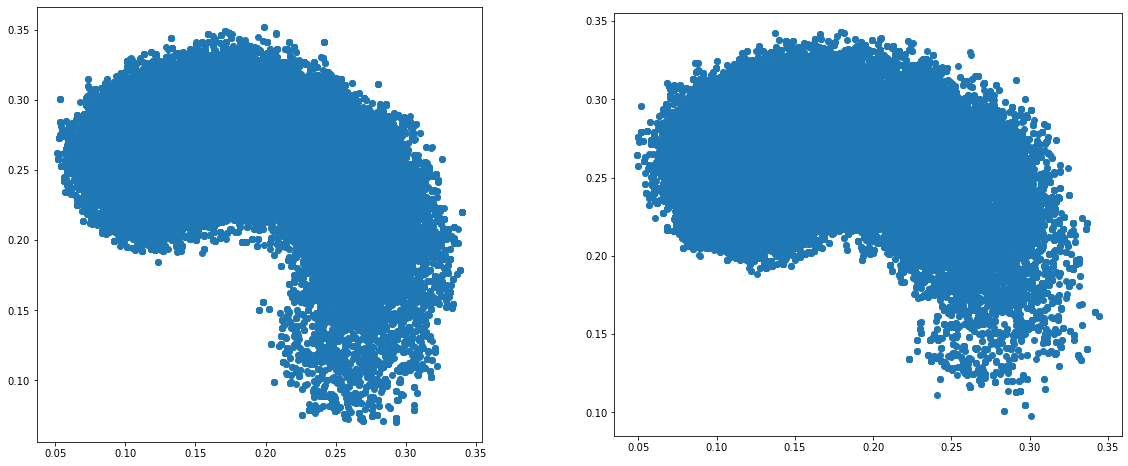

In [468]:
fig, ax = plt.subplots(figsize=(20,8), ncols=2)
ax[0].scatter(*out['HH']['SAMPLES'][:, :2].T)
ax[0].set_aspect("equal")
ax[1].scatter(*out['TH']['SAMPLES'][:, :2].T)
ax[1].set_aspect("equal")
plt.show()

In [469]:
out['HH']['A1'], *out['TH']['A1']

(55.88400000002233, 53.94000000001996)

In [470]:
out['HH']['UNIQUE'], *out['TH']['UNIQUE']

(39231, 38076.0)

In [471]:
out['HH']['A2'], *out['TH']['A2']

(22.577999999998365, 22.211999999998568)

In [472]:
!say FINISHED

In [473]:
"{:.5}, {:.5}, {:.5}, {:.5}".format(*ESS_univariate(out['HH']['SAMPLES']))

'9.779, 24.084, 7.8986, 8323.4'

In [474]:
"{:.5}, {:.5}, {:.5}, {:.5}".format(*ESS_univariate(out['TH']['SAMPLES']))

'8.9082, 73.629, 7.2554, 6698.9'

In [475]:
ESS(out['HH']['SAMPLES']), ESS(out['TH']['SAMPLES'])

(1362.2993709943967, 1482.8623115683192)

I need to see what the HOP kernel looks like on some samples... Notice that the space is $4$ dimensional. The $\theta$ space is only the first two coordinates

In [458]:
def Hop_Candidates(x, lam, k, logpi, grad_log_pi):
    d = len(x)
    # Compute matrix square root
    mu_sq = k * lam
    mu = np.sqrt(mu_sq)
    lam_sq = lam**2
    # Compute normalized gradient at x
    gx = grad_log_pi(x)
    ngx = norm(gx)
    ghatx = gx / ngx
    # Sample from standard MVN
    u = multivariate_normal(np.zeros(d), np.eye(d)).rvs()
    # Transform to new sample
    y = x + ((mu*u + (lam - mu) * ghatx * (ghatx @ u)) / np.sqrt(max(1.0, ngx**2)))
    return y, 0.0

def hop_samples(x, N):
    samples = x
    for _ in range(N):
        y, _ = Hop_Candidates(x, lam, kappa, log_abc_posterior, grad_function)
        samples = vstack((samples, y))
    return samples

In [459]:
lam = epsilon 
kappa = 0.001
initial = out['HH']['SAMPLES'][4000]
hop_stuff = hop_samples(initial, 1000)

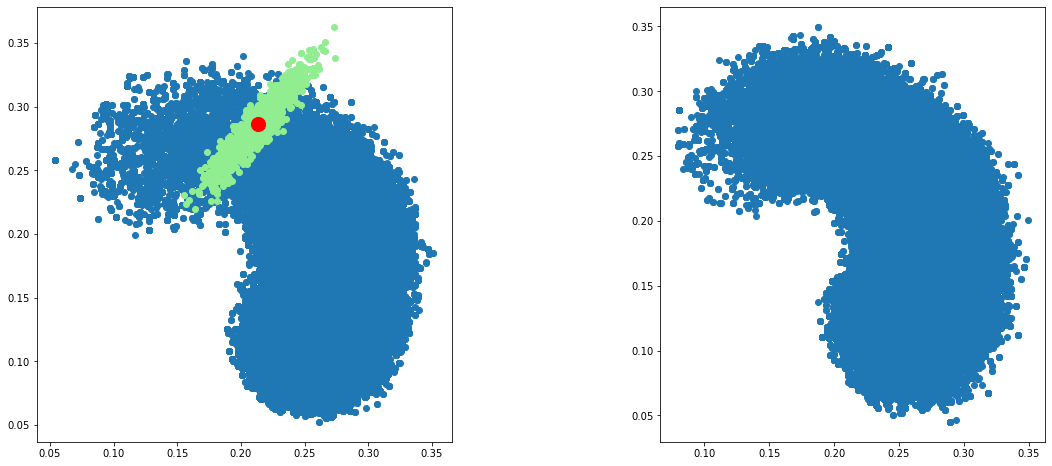

In [460]:
fig, ax = plt.subplots(figsize=(20,8), ncols=2)
ax[0].scatter(*out['HH']['SAMPLES'][:, :2].T)
ax[0].set_aspect("equal")
ax[0].scatter(*hop_stuff[:, :2].T, color='lightgreen')
ax[0].scatter(*initial[:2], s=200, color='red')
ax[1].scatter(*out['TH']['SAMPLES'][:, :2].T)
ax[1].set_aspect("equal")
plt.show()